# **트레이딩 전략과 구현 6장 포트폴리오 이론**
**[파이썬 증권 데이터 분석 6장 | nbviewer](https://nbviewer.jupyter.org/github/INVESTAR/StockAnalysisInPython/tree/master/06_Trading_Strategy/)**
- **변동성 돌파, 추세추종, 반전** 3가지 매매기법 존재
- **추세추종, 반전 매매기법** 2가지를 확인해 본다

# **1 반전 (Reversals) 매매기법 (볼린저 밴드 매매기법2)**
- **<span style="color:orange">일중 강도율 (Intraday Intensity)</span>** 와 **<span style="color:orange">매집 분산율 (AD%)</span>** 을 기술적 지표로 활용
- 둘 중 **<span style="color:orange">일중 강도율(II%)</span>** 하나만 활용하여 매매한다

## **01 데이터 불러오기 + 볼린저 밴드 추가**
loading the Naver Stock Price Table

In [1]:
import os
import pandas as pd
file_save = "stock/boillingeSkHy.csv"
if os.path.isfile(file_save):
    data_df = pd.read_csv(file_save)
    data_df['Date'] = pd.to_datetime(data_df['Date']) # datetime 포맷 변경
    data_df = data_df.set_index('Date')
else:
    from FinanceDataReader import DataReader as fdr
    data_df = fdr("000660", "2019-01-01")
    data_df.to_csv(file_save)

data_df.columns = [_.lower() for _ in data_df.columns]
data_raw = data_df.copy()
data_df.tail(3)

,open,high,low,close,volume,change
Date,,,,,,
2021-05-04,130500,132000,129000,132000,2547004,0.003802
2021-05-06,130000,130500,128000,129000,4211535,-0.022727
2021-05-07,128000,131000,127000,129500,3421855,0.003876


## **02 일중 강도율**
거래 범위 내에서 **<span style="color:orange">종가의 위치</span>** 를 토대로 종목내 자금 흐름을 설명한다

$$ 일중강도 = {\frac{2 \times close-high-low}{high-low}} \times volume $$
$$ 일중 강도율 = {\frac{ 일중강도 21일 합계 }{ 거래량 21일 합계 }} \times 100 $$

In [7]:
# 볼린저 밴드 계산하기
data_df['MA20'] = data_df['close'].rolling(window=20).mean() 
data_df['stddev'] = data_df['close'].rolling(window=20).std() 
data_df['upper'] = data_df['MA20'] + (data_df['stddev'] * 2)
data_df['lower'] = data_df['MA20'] - (data_df['stddev'] * 2)
data_df['PB'] = (data_df['close'] - data_df['lower'])\
        / (data_df['upper'] - data_df['lower'])

# 일중강도 : 일중 강도율 계산하기
data_df['II'] = (2 * data_df['close'] - data_df['high'] - data_df['low'])\
        / (data_df['high'] - data_df['low']) * data_df['volume']
# 일중강도율 : 21간의 일중 강도율 합계
data_df['IIP21'] = data_df['II'].rolling(window=21).sum()\
        / data_df['volume'].rolling(window=21).sum()*100
data_df = data_df.dropna()

## **03 Visualization**
결과값 시각화 작업

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading ... Visualization Modules
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.font_manager import fontManager as fm # 한글폰트 확인 및 추가
font_list_check  = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']
for _ in font_list_check:
    font_counts = [f  for f in font_list_check if _ in [_.name for _ in fm.ttflist]]
    if len(font_counts) > 1: print(f"found : {_}"); plt.rc('font', family=_); break 

found : D2Coding


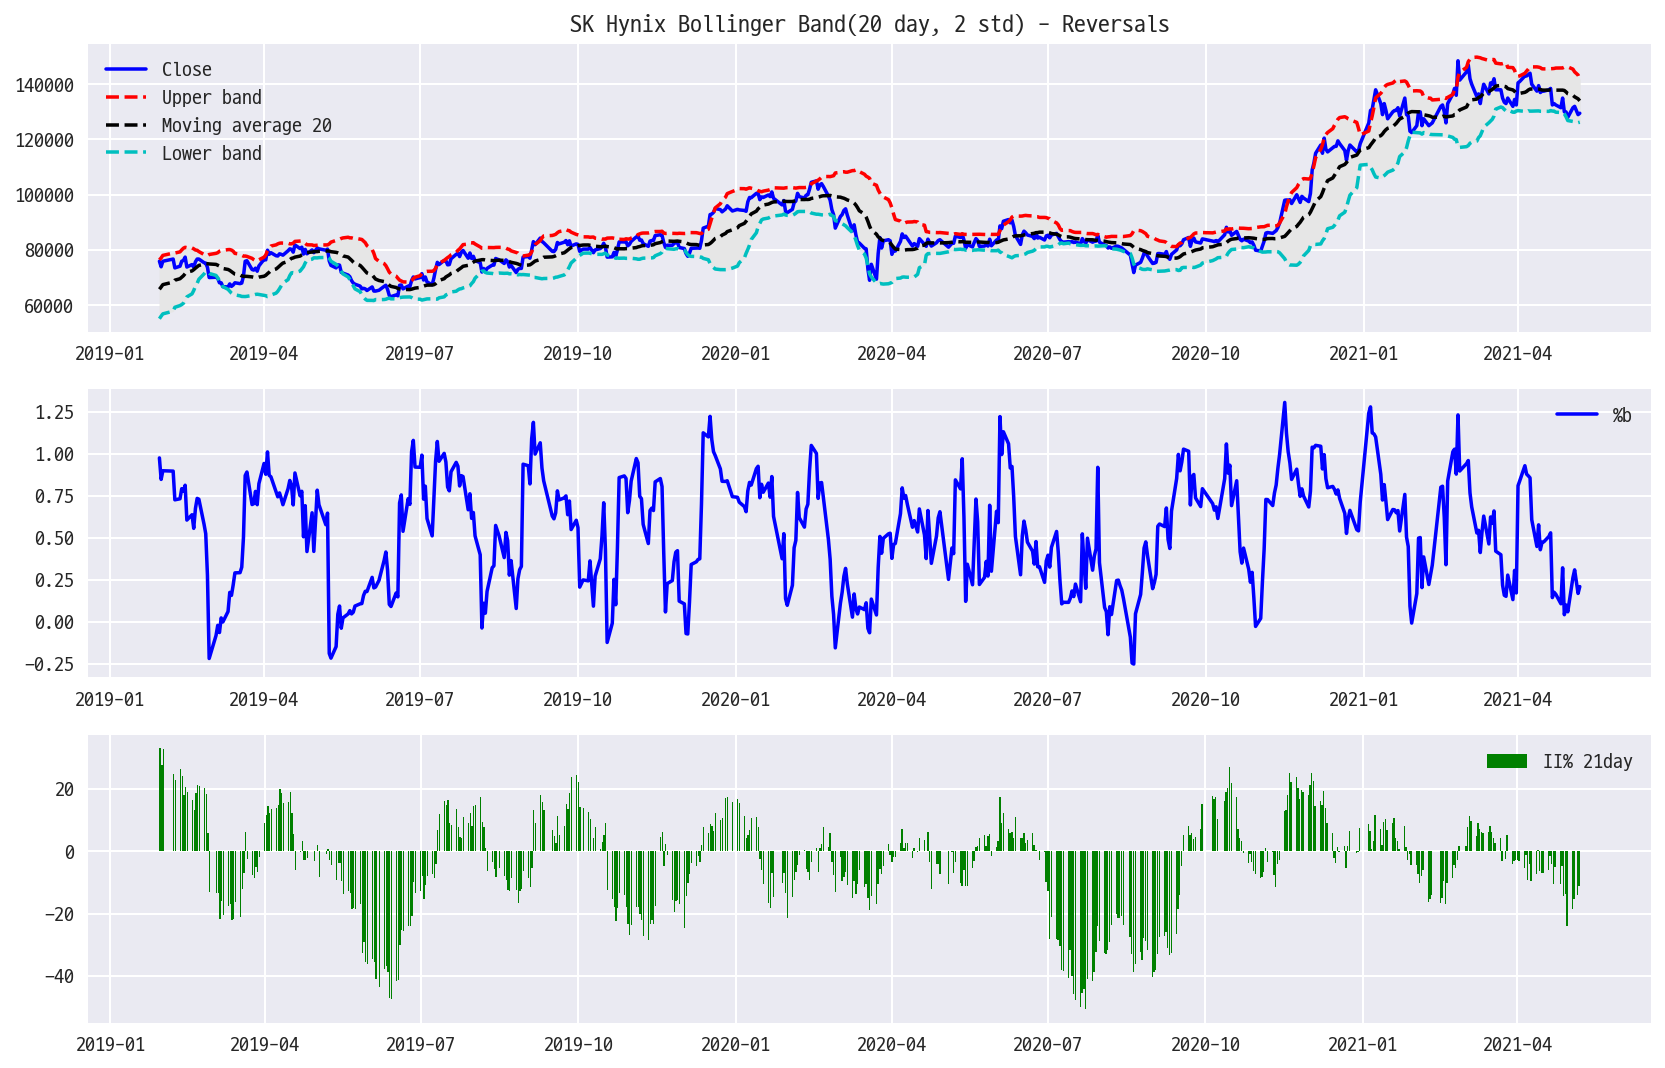

In [6]:
plt.figure(figsize=(14, 9))
plt.subplot(3, 1, 1)
plt.title('SK Hynix Bollinger Band(20 day, 2 std) - Reversals')
plt.plot(data_df.index, data_df['close'], 'b', label='Close')
plt.plot(data_df.index, data_df['upper'], 'r--', label ='Upper band')
plt.plot(data_df.index, data_df['MA20'], 'k--', label='Moving average 20')
plt.plot(data_df.index, data_df['lower'], 'c--', label ='Lower band')
plt.fill_between(data_df.index, data_df['upper'], data_df['lower'], color='0.9')

plt.legend(loc='best')
plt.subplot(3, 1, 2)
plt.plot(data_df.index, data_df['PB'], 'b', label='%b')
plt.grid(True)
plt.legend(loc='best')

plt.subplot(3, 1, 3)  # ③
plt.bar(data_df.index, data_df['IIP21'], color='g', label='II% 21day')  # ④
plt.grid(True)
plt.legend(loc='best')
plt.show()